# Computing wavelet packet entropy features in python

In this notebook, we will compute wavelet packet entropy features in python. We had already computed wavelet packet entropy features in MATLAB. Those calculations can be found [here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/calculate_wavelet_packet_entropy_features.ipynb). This notebook is for the benefit of python users who are not familiar with MATLAB. As exact MATLAB equivalent commands are not available in Python, our computed feature matrix will not match exactly with the one [available online](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/feature_wav_ent8_shan_48k_2048_load_1.csv). But we will get pretty close values. For further demonstration, we will also use the feature matrix computed in this notebook to train an SVM model for multiclass fault classification. Again, the accuracy we obtain in this notebook will not match exactly with the accuracy that we had obtained using MATLAB feature matrix. But the accuracy values are also close.

Note that we will **not** use the feature matrix obtained in this notebook to apply other machine learning techniques. We have already applied various machine learning methods to wavelet packet features (feature matrix obtained using MATLAB). All those results can be found [here](https://biswajitsahoo1111.github.io/cbm_codes_open/).

In python, we will use [PyWavelets package](https://github.com/PyWavelets/pywt) to compute wavelet features. Also note that we will not go into the theory of wavelet in this notebook. For the theory, we point readers to the following three excellent resources:

* Section 8.8 to Section 8.11 of Foundations of Applied Mathematics, Volume 2 by Jeffrey Humpherys and Tyler J. Jarvis
* Introduction to Wavelets and Wavelet Transforms: A Primer by C. Sidney Burrus, Ramesh A. Gopinath, and Haitao Guo
* Wavelets AND Filter Banks by Gilbert Strang and Truong Nguyen 

Readers who want a quick introduction to wavelets should read only the sections on "Haar" wavelets as those are the simplest and easiest to understand. Rest of the theory in wavelets are generalizations of Haar case with some new ideas. Readers should also read the documentation of PyWavelets to see what the functions do and what the inputs to those functions are.

In [4]:
import pywt
import numpy as np

In [5]:
print("PyWavelets Version: ", pywt.__version__)

PyWavelets Version:  1.4.1


Download the time domain data from [here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/CWRU_48k_load_1_CNN_data.npz) and run the following cells. See [this notebook](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/CWRU_time_domain_data_preprocessing.ipynb) to understand how the time domain data was prepared at the first place. This data will be used later in [deep learning demonstration](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Deep_Learning_CWRU_Blog.ipynb). We use the same time domain data and calculate features from it.

In [6]:
# file = np.load("/home/biswajit/data/CWRU_48k_load_1_CNN_data.npz")
# print(file.files)

In [7]:
# data = file["data"]
# labels = file["labels"]
# print(data.shape, labels.shape)

In [8]:
import h5py
import torch

In [9]:
def load_dict_from_hdf5(filename):
    """
    Load a dictionary of lists of arrays from an HDF5 file.

    Parameters:
    filename (str): The name of the HDF5 file to load the data from.

    Returns:
    dict: The dictionary containing lists of arrays.
    """
    data_dict = {}
    with h5py.File(filename, 'r') as hdf5_file:
        for key in hdf5_file.keys():
            group = hdf5_file[key]
            data_dict[key] = np.array([group[f'array_{i}'][...] for i in range(len(group))])
    return data_dict

data_dict = load_dict_from_hdf5('final_data.h5')

We had divided the raw signal into segments of length 1024 each. For each fault type we had collected 460 segments. There are 10 fault types, so we get 4600 segments in total. As the data were prepared for a CNN task, we had further resized the data into a size of $(32 \times 32)$. So final size of data becomes $(4600 \times 32 \times 32)$.

In [11]:
# resized_data = np.reshape(data, (2300,2048))
# resized_data.shape

In [12]:
X = []
y = []

target = 0
skip = True
for key,value in data_dict.items():
    # if  skip:
    #     skip  = False
    #     continue
    n = value.shape[0]
    X.append(torch.tensor(np.array(value)))
    y.append(torch.ones(n,dtype=int)*target)
    target+=1

X = torch.cat(X).squeeze()
y = torch.cat(y)

In [13]:
resized_data = np.array(X)

We resize the data this way because for shallow learning applications we consider segments of length 2048 and calculate features using the data of this segment. There is no particular reason in choosing segments of length 2048 as opposed to 1024 or 4096 or any other number. One consideration might be the amount of raw data available. If we select a larger segment length, we will get less number of segments. And if we need more segments (this is a need in machine learning), we keep the segment length short. However, keep in mind that reducing the segment length to an arbitrarily small number might not be that useful as small segments might not capture useful events that are characteristic of bearing faults. It so happens that the author chose a segment length of 2048 for this dataset and the resulting feature matrix yielded excellent results. Thus, the author has not changed the segment length ever since.

To get a feel of the library, we will apply it to first row of `resized_data`. In the feature matrix, we will repeat the calculations for every row of `resized_data`.

In [14]:
wp = pywt.WaveletPacket(resized_data[0,:], wavelet = "sym8", maxlevel = 3) # Computes 3 level wavelet packet decomposition

In [15]:
packet_names = [node.path for node in wp.get_level(3, "natural")]  # Packet node names. 
packet_names  # The naming of nodes as "aaa", "aad" is conventional in wavelets. "a" means approximation. "d" means details.

['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']

In [16]:
[wp[node.path].data.shape for node in wp.get_level(3, "natural")] # Number of coefficients after 3 stage transformation.

[(8138,), (8138,), (8138,), (8138,), (8138,), (8138,), (8138,), (8138,)]

Now we will compute the feature matrix for whole dataset. We will use the packet names as extracted above. To compute wavelet packet entropy features, we will also need a function to compute entropy. The function is defined as below.

In [17]:
def compute_shannon_entropy(signal):
    """Here, we will compute nonnormalized shannon entropy.
    We will basically implement MATLAB function 'wentropy'.
    Input: signal should be 1D numpy array."""
    return -np.nansum(signal**2 * np.log(signal**2)) # nansum to exclude pesky terms like "0*np.log(0)"

In [36]:
n_examples = X.shape[0]

In [38]:
feature_matrix_wav_packet_entropy = np.repeat(np.nan, n_examples*8).reshape(n_examples,8)
for i in range(len(resized_data)):
    wp = pywt.WaveletPacket(resized_data[i,:], wavelet = "sym8", maxlevel = 3) # Wavelet packet transformation
    for j in range(8):
        new_wp = pywt.WaveletPacket(data = None, wavelet = "sym8", maxlevel = 3)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        feature_matrix_wav_packet_entropy[i,j] = compute_shannon_entropy(reconstructed_signal) # Entropy of reconstructed signal for every node
        # print(reconstructed_signal)
        # print(feature_matrix_wav_packet_entropy[i,j])

In [39]:
print(reconstructed_signal)
feature_matrix_wav_packet_entropy

[-2.22858766e-04 -7.00641483e-04  5.65704322e-04 ...  1.06075948e-03
 -7.12103135e-04 -4.27261121e-05]


array([[-1.88248751e+04,  5.21941505e+02,  1.98700798e+01, ...,
         6.63589384e+00,  1.15752605e+01,  8.03922754e+00],
       [-5.74463784e+05,  5.03529661e+02,  1.89061437e+01, ...,
         6.69171152e+00,  9.57090398e+00,  7.67477292e+00],
       [-6.16416112e+04,  3.02757137e+03,  1.35207712e+02, ...,
         1.80110415e+01,  5.65475897e+01,  3.09559774e+01],
       ...,
       [ 6.39297422e+03,  2.30609333e+03,  2.73653852e+02, ...,
         1.65647946e+00,  8.92334518e+01,  1.84030704e+01],
       [ 7.19184377e+03,  2.00671567e+03,  1.72466218e+02, ...,
         1.48501092e+00,  4.32684397e+01,  1.48268717e+01],
       [ 6.86725000e+02,  1.65301549e+00,  1.27178882e+00, ...,
         9.81306795e-04,  5.44393283e-01,  3.36782485e-02]])

Now that feature matrix is ready, we will use it in an SVM model for multiclass fault classification. See [this notebook](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/SVM_wavelet_entropy_multiclass_cwru_python.ipynb) for reference.

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
categories = ["Ball_007_1", "Ball_014_1", "Ball_021_1", "IR_007_1", "IR_014_1", "IR_021_1",
              "OR_007_6_1", "OR_014_6_1", "OR_021_6_1", "Normal_1"]

In [44]:
# We are overwriting old labels as we need only 2300 labels.
labels = pd.Categorical(np.repeat(categories, repeats = 230), categories = categories)
labels = np.array(y)

Divide the into training and test set.

In [59]:
train_data, test_data, train_labels, test_labels = train_test_split(feature_matrix_wav_packet_entropy, labels,
                                                                    train_size = 700, stratify = labels,
                                                                    random_state = 123)
# test_labels.value_counts()

Before applying SVM, it is always a better idea to scale the data.

In [60]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

We will check a grid of parameters to find the best one. For each parameter combination, 10 fold cross-validation is performed.

In [61]:
parameters = {"C":[1, 10, 50, 100, 500, 1000, 5000],
             'gamma':[0.05, 0.1, 0.5, 1, 5],
             'kernel':["rbf"]}

In [62]:
tuned_svm_clf = GridSearchCV(SVC(),parameters,n_jobs = -1, cv= 10)

In [63]:
tuned_svm_clf.fit(train_data_scaled, train_labels)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 500, 1000, 5000],
                         'gamma': [0.05, 0.1, 0.5, 1, 5], 'kernel': ['rbf']})

In [64]:
tuned_svm_clf.best_score_

0.9985714285714286

In [65]:
tuned_svm_clf.best_params_

{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}

Now we will use the best model to find test accuracy.

In [66]:
best_clf = tuned_svm_clf.best_estimator_
best_clf

SVC(C=1, gamma=0.05)

In [67]:
train_predictions = best_clf.predict(train_data_scaled)
test_predictions = best_clf.predict(test_data_scaled)

In [68]:
train_confu_matrix = confusion_matrix(train_labels, train_predictions)
test_confu_matrix = confusion_matrix(test_labels, test_predictions)

Train confusion matrix.

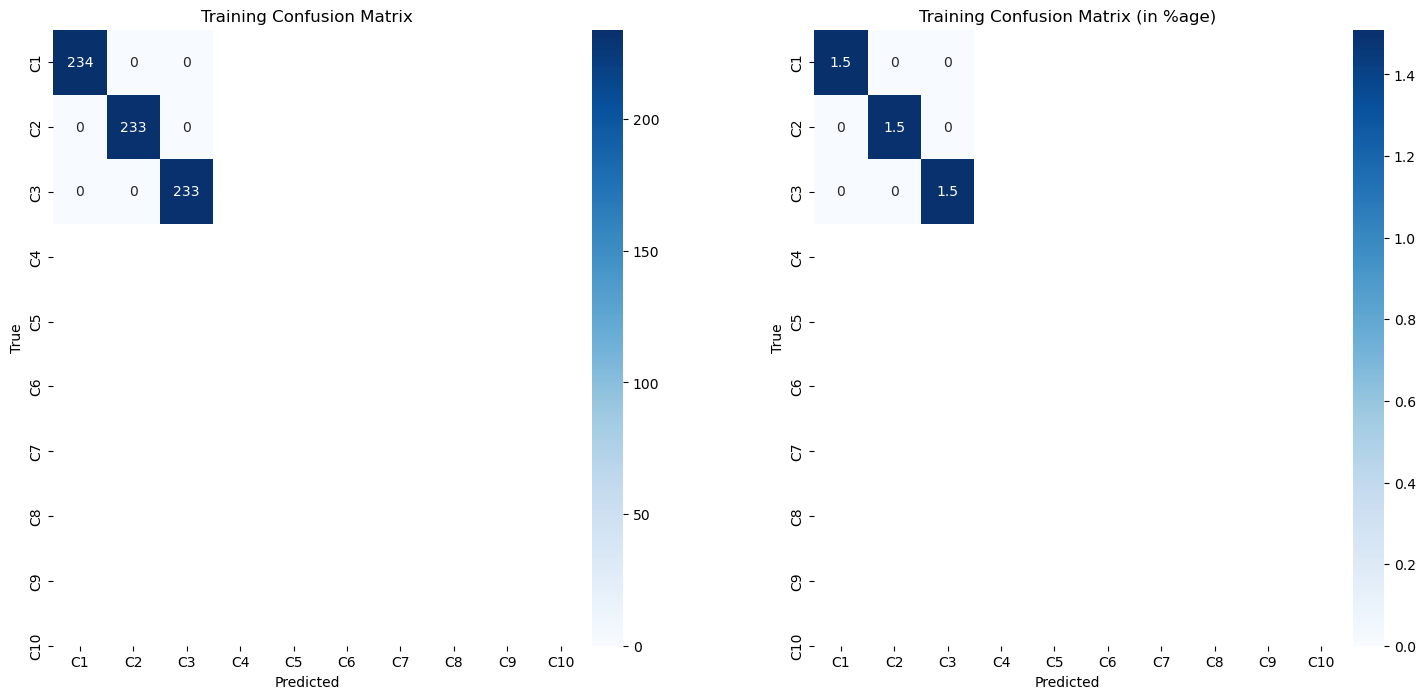

In [69]:
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(1,figsize=(18,8))
plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix/155, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Test confusion matrix.

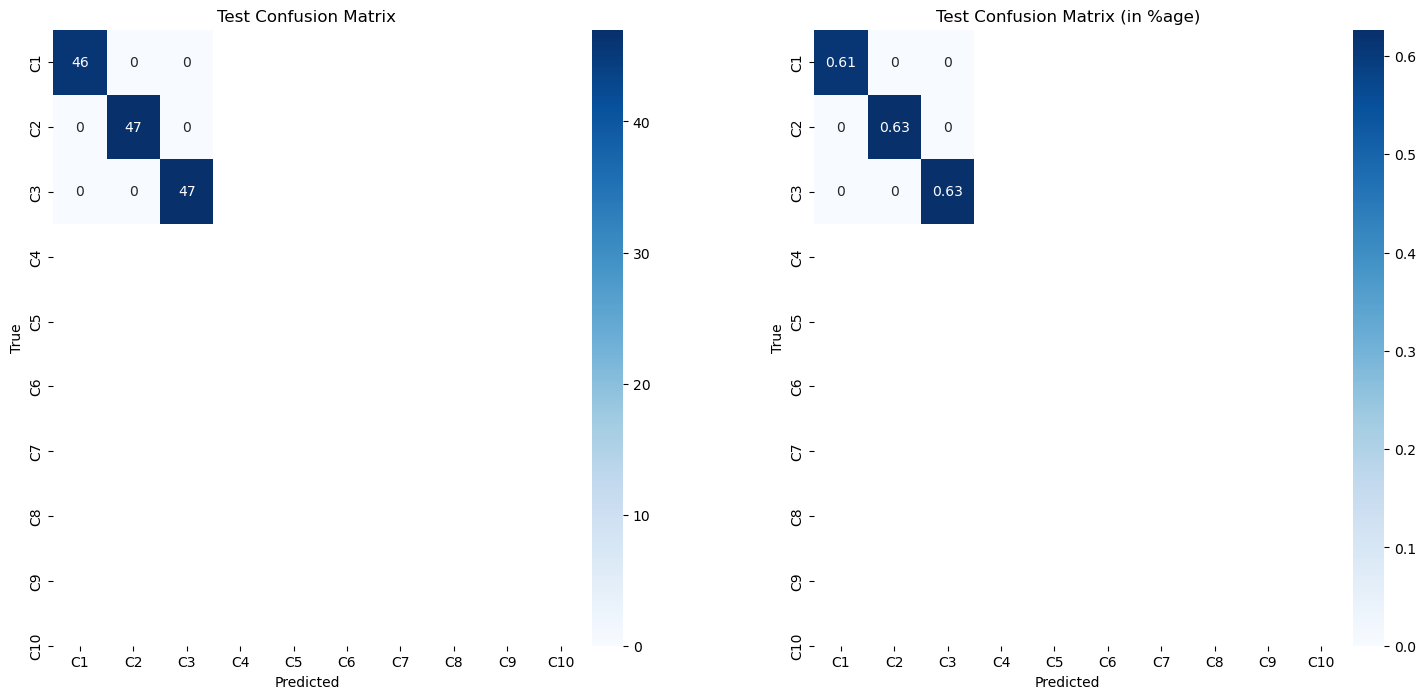

In [70]:
plt.figure(2,figsize=(18,8))
plt.subplot(121)
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix/75, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Test Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [71]:
overall_test_accuracy = accuracy_score(test_labels, test_predictions)
print("Overall test accuracy: ", overall_test_accuracy)

Overall test accuracy:  1.0


Our overall accuracy is slightly less that what we had obtained previously. This is because our feature matrix in this case is slightly different than the previous one. However, the present accuracy is very close to the old accuracy.

Interested readers can visit my [project page](https://biswajitsahoo1111.github.io/cbm_codes_open/) for further results on applying machine learning techniques for condition monitoring applications.